In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
fastai.__version__

'1.0.37'

In [3]:
from fastai import *
from fastai_audio import *
from fastai.vision import models

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
DATA = Path('data')
AUDIO = DATA/'freesound/audio_22050_trimmed_tfms'

CSV = DATA/'freesound/audio_44KHz/train_with_lens.csv'
TEST_CSV = DATA/'freesound/audio_44KHz/test_with_lens.csv'

In [6]:
df = pd.read_csv(CSV)
if df['fname'].iloc[0].endswith('.wav'):
    df['fname'] = df['fname'].str[:-4]
    df.drop(['manually_verified'], axis=1, inplace=True)

#df.set_index('fname', inplace=True)

# validation split; stratified by label
idx = np.arange(len(df))
train_idx, valid_idx = train_test_split(idx, test_size=0.2, stratify=df['label'])
df['valid'] = False
df.loc[df.iloc[valid_idx].index, 'valid'] = True

df.head(10)

,fname,label,n_samples,valid
0,00044347,Hi-hat,617400,False
1,001ca53d,Saxophone,455112,True
2,002d256b,Trumpet,19404,False
3,0033e230,Glockenspiel,352800,True
4,00353774,Cello,199332,False
5,003b91e8,Cello,585648,False
6,003da8e5,Knock,59976,False
7,0048fd00,Gunshot_or_gunfire,45864,True
8,004ad66f,Clarinet,308700,True
9,0063ab88,Computer_keyboard,1307124,False


In [7]:
def tfm_df(df, n_tfms=5):
    dfs = []
    for i in range(n_tfms + 1):
        suffix = '_{:02d}'.format(i)
        new_df = df.copy()
        new_df['fname'] = new_df['fname'] + suffix
        dfs.append(new_df)
    tfm_df = pd.concat(dfs)
    return tfm_df
        
df_tfm = tfm_df(df)
df_tfm.head(5)

,fname,label,n_samples,valid
0,00044347_00,Hi-hat,617400,False
1,001ca53d_00,Saxophone,455112,True
2,002d256b_00,Trumpet,19404,False
3,0033e230_00,Glockenspiel,352800,True
4,00353774_00,Cello,199332,False


In [8]:
# two files were corrupt when generating transformed files, just remove them from df
df_tfm = df_tfm[~df_tfm['fname'].isin(['255db1a8_05', 'f406520b_01'])]

In [9]:
len(df_tfm)

56836

In [10]:
drop_idx = (df_tfm['valid'] == True) & (~df_tfm['fname'].str.endswith('_00'))

In [11]:
df_final = df_tfm[~drop_idx]

In [12]:
df_final['valid'].sum()

1895

In [13]:
(~df_final['valid']).sum()

45466

In [14]:
n_fft = 2048
n_hop = 512
n_mels = 128
sample_rate = 22050
top_db = 50.0
ref = 1.0

bs = 8

In [26]:
def rand_crop(signal):
    start_pct = 0.1
    end_pct = 0.4
    max_start = signal.shape[0] * start_pct
    max_end = signal.shape[0] * end_pct
    crop_start = int(np.random.rand() * max_start)
    crop_end = int(np.random.rand() * max_end) + 1
    return signal[crop_start:-crop_end]

def random_stretch(mags, phases):
    pct = 0.2
    a,b = 1.0-pct, 1.0+pct
    r = np.random.rand() * (a - b) + b
    return phase_vocoder(mags, phases, rate=r)

def random_stretch_mags(mags):
    pct = 0.2
    a,b = 1.0-pct, 1.0+pct
    r = np.random.rand() * (a - b) + b
    return phase_vocoder_magnitude(mags, rate=r)

def get_transforms(n_fft=1024, n_hop=256, n_mels=96, sample_rate=16000):
    window = torch.hann_window(n_fft)
    to_db = ToDecibels(power=2, ref=ref, top_db=top_db, normalized=True)
    to_mel = FrequencyToMel(n_mels=n_mels, n_fft=n_fft, sr=sample_rate)
    to_mel.mel_filterbank = to_cpu(to_mel.mel_filterbank)

    def _train_tfm(x):
        if x.shape[0] == 0:
            x = torch.zeros(n_hop * 2)
        x = rand_crop(x)
        X = stft(x, n_fft=n_fft, hop_length=n_hop, window=window)
        power = power_spectrum(X)
        power = random_stretch_mags(power)
        power.unsqueeze_(0)
        mel_power = to_mel(power.transpose(1,2))
        mel_power_db = to_db(mel_power).squeeze_(0)
        return mel_power_db
    
    def _valid_tfm(x):
        if x.shape[0] == 0:
            x = torch.zeros(n_hop * 2)
        X = stft(x, n_fft=n_fft, hop_length=n_hop, window=window)
        power = power_spectrum(X).unsqueeze_(0)
        mel_power = to_mel(power.transpose(1,2))
        mel_power_db = to_db(mel_power).squeeze_(0)
        return mel_power_db
    
    return [_train_tfm],[_valid_tfm]

In [16]:
def add_channel_dim(inputs):
    xs, ys = inputs
    xs.unsqueeze_(1)
    return xs, ys

In [17]:
test_df = pd.read_csv(TEST_CSV)
test_data = AudioItemList.from_df(test_df, path=AUDIO, folder='test', suffix='.wav')

In [27]:
def get_transforms(n_hop=256):
    def _train_tfm(x):
        if x.shape[0] == 0:
            x = torch.zeros(n_hop * 2)
        x = rand_crop(x)
        return x
    
    def _valid_tfm(x):
        if x.shape[0] == 0:
            x = torch.zeros(n_hop * 2)
        return x
    
    return [_train_tfm],[_valid_tfm]

In [18]:
n_fft = 2048
n_hop = 256
n_mels = 128

tfms = get_transforms(n_hop=n_hop)

batch_tfms = get_frequency_batch_transforms(n_fft=n_fft, n_hop=n_hop,
                                            n_mels=n_mels, sample_rate=sample_rate)


data = (AudioItemList
            .from_df(df_final, path=AUDIO, folder='train', suffix='.wav')
            .split_from_df('valid')
            .label_from_df()
            .add_test(test_data)
            .transform(tfms)
            .databunch(bs=bs, equal_lengths=False, tfms=batch_tfms, length_col=2))

In [19]:
learn = create_cnn(data, models.resnet34, metrics=[error_rate, mapk])
model_name = 'freesound_22khz_tfms_v1'
learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,error_rate,mapk
1,2.259749,1.977386,0.521372,0.588742
2,1.792742,1.547110,0.403694,0.685840
3,1.552998,1.325636,0.349340,0.730519
4,1.414393,1.087369,0.304485,0.771240
5,1.208506,0.998136,0.268602,0.796746
6,1.139742,0.987187,0.273351,0.795954
7,0.999353,0.949563,0.259631,0.804310
8,0.945886,0.992560,0.261741,0.803518


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


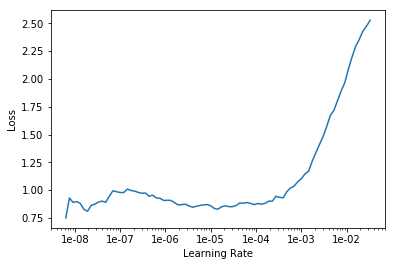

In [20]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.lr_find(start_lr=1e-9, end_lr=1e-1)
learn.recorder.plot()

In [21]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-4))
learn.save(model_name + '-stage-2')

epoch,train_loss,valid_loss,error_rate,mapk
1,1.081051,0.953421,0.246438,0.813193
2,0.860056,0.864181,0.234301,0.826297
3,0.639508,0.819855,0.212137,0.842920
4,0.492429,0.824704,0.198417,0.851188
5,0.416053,0.803694,0.194723,0.856904
6,0.261583,0.823877,0.194723,0.856201
7,0.285006,0.823400,0.191557,0.858135
8,0.242557,0.801174,0.185752,0.862005


In [123]:
def save_submission(learner, filename, tta=False):
    fnames = [Path(f).name for f in learn.data.test_ds.x.items]
    get_predsfn = learn.TTA if tta else learn.get_preds
    preds = get_predsfn(ds_type=DatasetType.Test)[0]
    top_3 = np.array(learn.data.classes)[np.argsort(-preds, axis=1)[:, :3]]
    labels = [' '.join(list(x)) for x in top_3]
    df = pd.DataFrame({'fname': fnames, 'label': labels})
    df.to_csv(filename, index=False)
    return df

In [23]:
learn.load(model_name + '-stage-2')
df1 = save_submission(learn, '22khz_2048_256_pitch_tfms.csv', tta=False)

In [24]:
learn.load(model_name + '-stage-2')
df2 = save_submission(learn, '22khz_2048_256_pitch_tfms_all.csv', tta=True)

### Use all the data; try resnet18 for less overfitting

In [42]:
n_fft = 2048
n_hop = 256
n_mels = 128

tfms = get_transforms(n_hop=n_hop)

batch_tfms = get_frequency_batch_transforms(n_fft=n_fft, n_hop=n_hop,
                                            n_mels=n_mels, sample_rate=sample_rate)


data = (AudioItemList
            .from_df(df_final, path=AUDIO, folder='train', suffix='.wav')
            .random_split_by_pct(0.0001)
#             .random_split_by_pct()
            .label_from_df()
            .add_test(test_data)
            .transform(tfms)
            .databunch(bs=bs, equal_lengths=False, tfms=batch_tfms, length_col=2))
# data

len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(47359, 4, 9400)

In [38]:
# from utils import transform_path

# def _check_file(filename, src_path, dst_path):
#     try:
#         x, sr = read_file(filename, path=src_path)
#     except Exception as e:
#         print(filename, type(e))

# transform_path(AUDIO/'train', Path('.'), _check_file)

In [43]:
learn = create_cnn(data, models.resnet18, metrics=[error_rate, mapk])
model_name = 'freesound_22khz_tfms_v2_resnet18_all'
learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,error_rate,mapk
1,2.364804,1.603008,0.250000,0.750000
2,1.824396,1.460186,0.250000,0.750000
3,1.643768,1.672498,0.500000,0.500000
4,1.433808,2.058769,0.750000,0.416667
5,1.381581,1.281553,0.500000,0.625000
6,1.228942,1.610711,0.500000,0.666667
7,1.257325,1.630744,0.500000,0.625000
8,1.295026,1.690066,0.750000,0.375000


In [44]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-4))
learn.save(model_name + '-stage-2')

epoch,train_loss,valid_loss,error_rate,mapk
1,1.067929,1.095641,0.500000,0.625000
2,0.961087,1.252828,0.500000,0.708333
3,0.838382,0.868915,0.500000,0.708333
4,0.680144,0.574667,0.250000,0.875000
5,0.540568,0.187176,0.000000,1.000000
6,0.451765,0.293206,0.000000,1.000000
7,0.468364,0.236443,0.000000,1.000000
8,0.468815,0.231896,0.000000,1.000000


In [47]:
learn.load(model_name + '-stage-2')
df1 = save_submission(learn, '22khz_2048_256_pitch_tfms_resnet18.csv', tta=False)

In [48]:
learn.load(model_name + '-stage-2')
df2 = save_submission(learn, '22khz_2048_256_pitch_tfms_resnet18_tta.csv', tta=True)

### Use all the data, and pad_crop transform

In [32]:
def rand_pad_crop(signal, pad_start_pct=0.1, crop_end_pct=0.5):
    r_pad, r_crop = np.random.rand(2)
    pad_start = int(pad_start_pct * r_pad * signal.shape[0])
    crop_end  = int(crop_end_pct * r_crop * signal.shape[0]) + 1
    return F.pad(signal[:-crop_end], (pad_start, 0), mode='constant')

In [33]:
def get_transforms(n_hop=256, n_fft=2048):
    min_len = n_fft
    def _train_tfm(x):
        x = rand_pad_crop(x)
        if x.shape[0] < min_len:
            x = F.pad(x, (0, min_len - x.shape[0]), mode='constant')
        return x
    
    def _valid_tfm(x):
        if x.shape[0] < min_len:
            x = F.pad(x, (0, min_len - x.shape[0]), mode='constant')
        return x
    
    return [_train_tfm],[_valid_tfm]

In [70]:
defaults.device = torch.device(0)

In [120]:
n_fft = 2048
n_hop = 256
n_mels = 128
sample_rate = 22050
bs = 8

tfms = get_transforms(n_hop=n_hop)

batch_tfms = get_frequency_batch_transforms(n_fft=n_fft, n_hop=n_hop,
                                            n_mels=n_mels, sample_rate=sample_rate)

test_df = pd.read_csv(TEST_CSV)
test_data = AudioItemList.from_df(test_df,
                                  path=AUDIO, 
                                  folder='test', 
                                  suffix='.wav')

# model fails if it is trained with a batch of size 1, so we use 47360 instead of 47361 
data = (AudioItemList
            .from_df(df_final, path=AUDIO, folder='train', suffix='.wav')[:47360]
            .no_split()
            .label_from_df()
            .add_test(test_data)
            .transform(tfms)
            .databunch(bs=bs, equal_lengths=False, tfms=batch_tfms, length_col=2))
len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(47360, 1, 9400)

In [125]:
learn = create_cnn(data, models.resnet34, metrics=[accuracy, mapk])
model_name = 'freesound_22khz_tfms_v3_resnet34_all'
learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

In [126]:
save_submission(learn, 'freesound_22khz_tfms_v3_resnet34_all_8.csv', tta=False)

,fname,label
0,00063640.wav,Bass_drum Snare_drum Hi-hat
1,0013a1db.wav,Flute Oboe Meow
2,002bb878.wav,Bass_drum Snare_drum Knock
3,002d392d.wav,Bass_drum Cello Snare_drum
4,00326aa9.wav,Oboe Gong Flute
5,0038a046.wav,Bass_drum Knock Computer_keyboard
6,003995fa.wav,Squeak Meow Fireworks
7,005ae625.wav,Acoustic_guitar Gong Harmonica
8,007759c4.wav,Flute Chime Clarinet
9,008afd93.wav,Saxophone Flute Clarinet


In [128]:
# save_submission(learn, 'freesound_22khz_tfms_v3_resnet34_all_8_tta.csv', tta=True)

In [130]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(1e-5,1e-4))
learn.save(model_name + '-stage-2')

In [131]:
save_submission(learn, 'freesound_22khz_tfms_v3_resnet34_all_12.csv', tta=False)

,fname,label
0,00063640.wav,Computer_keyboard Telephone Scissors
1,0013a1db.wav,Flute Oboe Trumpet
2,002bb878.wav,Bass_drum Telephone Cowbell
3,002d392d.wav,Bass_drum Telephone Cello
4,00326aa9.wav,Oboe Electric_piano Telephone
5,0038a046.wav,Bass_drum Double_bass Cello
6,003995fa.wav,Squeak Writing Tearing
7,005ae625.wav,Acoustic_guitar Snare_drum Chime
8,007759c4.wav,Clarinet Saxophone Gong
9,008afd93.wav,Saxophone Microwave_oven Flute


In [132]:
save_submission(learn, 'freesound_22khz_tfms_v3_resnet34_all_12_tta.csv', tta=True)

,fname,label
0,00063640.wav,Computer_keyboard Telephone Scissors
1,0013a1db.wav,Flute Oboe Harmonica
2,002bb878.wav,Bass_drum Telephone Violin_or_fiddle
3,002d392d.wav,Bass_drum Snare_drum Telephone
4,00326aa9.wav,Oboe Electric_piano Telephone
5,0038a046.wav,Bass_drum Double_bass Cello
6,003995fa.wav,Squeak Meow Writing
7,005ae625.wav,Acoustic_guitar Snare_drum Gong
8,007759c4.wav,Clarinet Saxophone Telephone
9,008afd93.wav,Saxophone Flute Microwave_oven
